In [2]:
# Install part
!pip install torch torchvision matplotlib tqdm numpy

## Training Deep Neural nets
* 512,314,830 trainable parameters
* User-defined cross-entropy loss and Conv2d function as PyTorch module
* Different types of initialization methods

#### Part 0, 1 and 2 

loss:-0.0120: 100%|██████████| 800/800 [04:29<00:00,  3.99it/s]


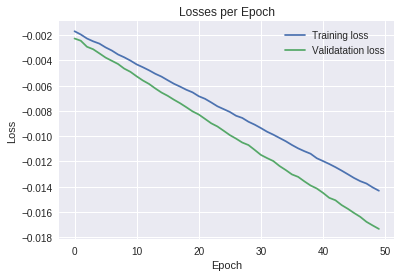

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pdb

# Instruct matplotlib to draw inline
%matplotlib inline

# See if the cuda is avaliable and store it in device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def orthogonal_weights(dims):
  # Using SVD to find the orthogonal matrices
  X = np.random.random(dims)
  U,_,Vt = np.linalg.svd(X, full_matrices=False)
  W = Vt.reshape(dims)
  return torch.from_numpy(W.astype(np.float32))

def uniform_weights(min, max, dims):
  # numpy function uniform and convert to torch Tensor
  return torch.from_numpy(np.random.uniform(min, max, size=dims).astype(np.float32))

def he_weights(fanin, fanout, dims):
  # Define variance and mean and then call numpy function 
  var = 2.0 / (fanin + fanout)
  mean = 0
  # Use numpy function
  return torch.from_numpy(np.random.normal(mean, var, dims).astype(np.float32))


class CrossEntropyLoss(nn.Module):
  def __init__(self, input=None, target=None, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
  #  # self.init_params = locals()
    super(CrossEntropyLoss, self).__init__()
    self.__dict__.update(locals())


  def forward(self, input, target):
    # Computing the exponent function
    expval = torch.exp(input)
    # Find the softmax
    softmax =  expval / (torch.sum(expval, (1), keepdim=True))
    # Find the predicted values
    indx = torch.argmax(softmax, dim=1)
    b = range(softmax.shape[0])
    # Find the score related to the predicted values
    score = expval[b, indx]
    # Find how many prediction matched
    match = indx == target
    match = match.type(torch.cuda.FloatTensor)
    # Compute loss
    loss = (match * torch.log(score)) * -1 #+ (1-match) * torch.log(1-score) * -1
    # Return loss
    return torch.mean(loss)


  def extra_repr(self):
    pass


class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, intiweight='ot'):
    ## Three types of init possible: he, uf, ot 
    # self.init_params = locals()
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    
    # Define the dimensions needed on this layer
    weight_dims = (self.out_channels, self.in_channels, *kernel_size)
    
    # Define the Tensor parameter weight and bias 
    self.weight = Parameter(torch.Tensor(self.out_channels, self.in_channels, *kernel_size))
    self.bias = Parameter(torch.Tensor(out_channels))    
    
    # Based on which type of initilization to do init the weights and bias
    if intiweight == 'he':      
      self.weight.data = he_weights(in_channels, out_channels, weight_dims)

      self.bias.data = he_weights(in_channels, out_channels, out_channels)
    elif intiweight == 'uf':     
      self.weight.data = uniform_weights(-1, 1, weight_dims)

      self.bias.data = uniform_weights(0, 0, out_channels)     
    elif intiweight == 'ot':   
      self.weight.data = orthogonal_weights(weight_dims)
      # Not possbile to initialize bias this way
      #self.bias.data = orthogonal_weights(out_channels)
      self.bias.data.uniform_(0, 0)
    else:
      self.weight.data.uniform_(-1, 1)
    
      self.bias.data.uniform_(0, 0)

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

  def extra_repr(self):
    pass


# Define the neural nets module which inherits the nn.Module
class ConvNetwork(nn.Module):
    def __init__(self, dataset):
        super(ConvNetwork, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()
        out = 10
        # One of the way to define the neural nets layers
        # Experimented with a big Neural net to train more than million
        # parameter
        self.conv = nn.Sequential(
            Conv2d(1, 16, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            Conv2d(16, 32, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fcon = nn.Sequential(
            nn.Linear(7 * 7 * 256, 20000),
            nn.Dropout(),
            nn.Linear(20000, 10000),
            nn.Linear(10000, 5000),
            nn.Linear(5000, 2000),
            nn.Dropout(),
            nn.Linear(2000, 500),
            nn.Linear(500, out)
        )

    # Forward pass. Backward pass is automatically implemented
    def forward(self, x):
        n, c, h, w = x.size()
        convout = self.conv(x)
        # Need to reshape to get a dense representation for fully 
        # connected layers
        convout = convout.reshape(convout.size(0), -1)
        return self.fcon(convout)
      
      
# Defining custom dataset processor
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root=root, train=train,
            download=True, transform=transforms.ToTensor())
        # Identity matrix
        self.e = torch.eye(10)

    def __getitem__(self, i):
        x, y = self.data[i]
        # Only used if we want y as a scalar
        # return x, y.unsqueeze(0).float()
        # Y as an one hot encoding
        #return x, self.e[y].float()
        return x, y

    def __len__(self):
        return 1024 #len(self.data)

      
# Ploting the train loss   
def plot_train_loss(loss):
    #x = np.linspace(0, 2, 100)
    x = range(len(loss))

    plt.plot(x, loss, label='loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title("Training Loss per Epoch")

    plt.legend()

    plt.show()


# Ploting the train loss   
def plot_both_loss(loss, vloss):
    #x = np.linspace(0, 2, 100)
    x = range(len(loss))

    plt.plot(x, loss, label='Training loss')
    plt.plot(x, vloss, label='Validatation loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title("Losses per Epoch")

    plt.legend()

    plt.show()    
    

def validatation_loop():
  # Get the validation data and do a forward pass through the neural net
  loss_batch = []
  for x, y in valid_loader:
    # Send both data and lable to cuda
    x = x.cuda(async=True)
    y = y.cuda(async=True)
    # Do the forward pass 
    y_hat = model(x)
    # Compute the loss. Prediction vs Real value
    loss = loss_func(y_hat, y)
    
    # Add the loss to the list
    loss_batch.append(loss)
    
  loss = torch.mean(torch.tensor(loss_batch))
  return loss
    
# Load the training data in this case it Fashionmnist
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist',train=True)

# Load the validation data 
validatation_dataset = FashionMNISTProcessedDataset(
    '/tmp/fashionmnist',train=False)

# Build a neural net module passing this dataset
#model = Network(train_dataset)
model = ConvNetwork(train_dataset)

# Make sure that this model runs on cuda
model = model.cuda()

# Define the loss function. In this case MSELoss
loss_func = CrossEntropyLoss()

# Define the optimizer to use. In this case SGD
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Get the training data in a mini-batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
    shuffle=False, num_workers=2, pin_memory=True)

# Get the validatation data in a mini-batch
valid_loader = torch.utils.data.DataLoader(validatation_dataset, batch_size=64,
    shuffle=True, num_workers=2, pin_memory=True)

# Define a list to store all the losses
losses = []
valid_losses = []

# Define a tqdm instance to see the progress bar
loop = tqdm(total=len(train_loader)*50, position=0)

for epoch in range(50):
    # Define a list for batch loss
    batch_losses = []
    # For each data batch from training data
    for batch in train_loader:
        # batch[0] is the data and 1 is the label
        batch[0]=batch[0].cuda(async=True)
        batch[1]=batch[1].cuda(async=True)
        
        # Reset the grad value to zero
        optimizer.zero_grad()
        
        # Predicted value 
        y_hat = model(batch[0])
        
        # Compute the loss
        loss = loss_func(y_hat, batch[1])
        
        # Propagate the loss backward. Backprop
        loss.backward()
        
        #print (epoch, loss, loss1)
        # Update the weights
        optimizer.step()
        
        # Set the tqdm params
        loop.set_description('loss:{:.4f}'.format(loss.item()))
        loop.update(1)
        
        # Append the loss to compute the average
        batch_losses.append(loss)
    
    # Call the validatation step
    valid_loss = validatation_loop()
  
    # Compute average loss for that batch
    loss = torch.mean(torch.tensor(batch_losses))
    
    # Append the average loss to draw graph
    losses.append(loss)
    valid_losses.append(valid_loss)

# Close the loop display
loop.close()

# Draw the plot
plot_both_loss(losses, valid_losses)

## Part 3 Finding Trainable Model Parameters

In [5]:
# model.parameters()
value = sum(p.numel() for p in model.parameters() if p.requires_grad)
print ('Trainable parameters', "{:,}".format(value) )

Trainable parameters 512,314,830


## Part 4 (Parameters Quiz)


 #### Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) :  (out_channels=22, kernel_size=(3, 3), padding=(1, 1))

* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=(2, 2))

* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(6, 6))

#### Using a Kernel size of 5×5:

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2))

* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3, 3))

* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(9, 9)) 

#### Using Kernel size of 5×3:

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0))

* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1))

* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2))

* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8)) 

#### Determine the kernel that requires the smallest padding size to make the following mappings possible:

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) :  (out_channels=10, kernel_size=(2, 4), padding=(0, 0))

* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) :  (out_channels=22, kernel_size=(1, 1), padding=(0, 0))


In [31]:
!free


              total        used        free      shared  buff/cache   available
Mem:       13335228     7380424      157856      261120     5796948     8072368
Swap:             0           0           0
